In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


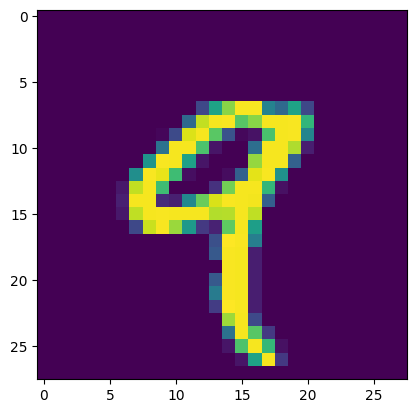

In [5]:
plt.imshow(train_input[4].view((28,28)))
plt.show()

In [6]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [7]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [8]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.tanh(x)**2

In [38]:
def loss (v,t):
    return torch.sum(torch.pow(input=v-t, exponent=2))

def dloss(v,t):
    return 2 * (v-t)

In [19]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 1.7325, -1.0175,  0.3882,  1.3850, -0.2000, -2.0367],
        [ 5.0491, -4.5309, -4.6107, -3.5940,  0.9823, -3.2926],
        [-4.3955,  0.9223, -1.2935, -1.6384, -2.5440, -1.6782]])

In [20]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [21]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [22]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50,))
w2 = torch.randn((50, 10))
b2 = torch.randn((10,))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [24]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.0514, grad_fn=<SumBackward0>))

In [25]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.05143356323242


In [27]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1)*dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2) * dh2
cmp('z2',dz2, z2)
dw2 = h1.T @ dz2 
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.T 
cmp('h1',dh1, h1)
dz1 = dsigma(z1) * dh1
cmp('z1', dz1, z1)
dw1 = x1.T @ dz1  
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
w2              | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: False | approximate: True  | maxdiff: 5.960464477539063e-08
z1              | exact: False | approximate: True  | maxdiff: 4.842877388000488e-08
w1              | exact: False | approximate: True  | maxdiff: 2.384185791015625e-07
b1              | exact: False | approximate: True  | maxdiff: 4.842877388000488e-08


In [28]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [29]:
l = loss(h2, y1)
l.item()

43.05143356323242

##### Now that we've checked our gradients are correct, we can implement the network

In [30]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2

In [31]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dsigma(z2)*dh2
    dw2 = h1.T @ dz2 
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.T 
    dz1 = dsigma(z1) * dh1
    dw1 = x1.T @ dz1 
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [33]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 -= lr * dw1
        b1 -= lr * db1.squeeze()
        w2 -= lr * dw2
        b2 -= lr * db2.squeeze()
    return w1, b1, w2, b2

In [34]:
def init():
    """ init a network """
    torch.manual_seed(2025)
    w1 = torch.randn((784, 50))
    b1 = torch.zeros((50,))
    w2 = torch.randn((50, 10))
    b2 = torch.zeros((10,))
    return w1, b1, w2, b2

In [35]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [54]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi     

In [55]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 9434.857421875
step = 100, loss = 8227.611328125
step = 200, loss = 7892.2666015625
step = 300, loss = 7642.99072265625
step = 400, loss = 7493.54833984375
step = 500, loss = 7353.35205078125
step = 600, loss = 7193.8408203125
step = 700, loss = 7069.201171875
step = 800, loss = 7003.50048828125
step = 900, loss = 6847.2451171875
step = 1000, loss = 6753.62353515625
step = 1100, loss = 6614.6982421875
step = 1200, loss = 6472.95849609375
step = 1300, loss = 6318.484375
step = 1400, loss = 6110.49365234375
step = 1500, loss = 5759.22802734375
step = 1600, loss = 5310.80078125
step = 1700, loss = 4840.01220703125
step = 1800, loss = 4686.5576171875
step = 1900, loss = 4481.244140625
step = 2000, loss = 3830.499267578125
step = 2100, loss = 3486.5712890625
step = 2200, loss = 3119.808349609375
step = 2300, loss = 2840.640869140625
step = 2400, loss = 2637.2998046875
step = 2500, loss = 2213.78564453125
step = 2600, loss = 1875.1607666015625
step = 2700, loss = 1792.757568

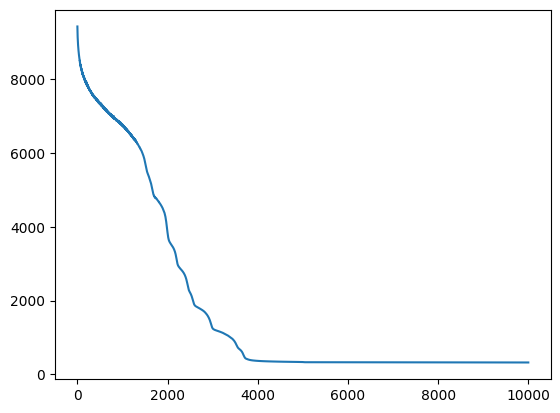

In [56]:
plt.plot(lossi)
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [57]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [58]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [59]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 9434.857421875
step = 100, loss = 8219.38671875
step = 200, loss = 7872.0908203125
step = 300, loss = 7666.02734375
step = 400, loss = 7492.92333984375
step = 500, loss = 7353.3369140625
step = 600, loss = 7194.37109375
step = 700, loss = 7086.01953125
step = 800, loss = 6963.8544921875
step = 900, loss = 6872.87353515625
step = 1000, loss = 6725.68701171875
step = 1100, loss = 6600.10107421875
step = 1200, loss = 6450.20703125
step = 1300, loss = 6274.89306640625
step = 1400, loss = 6078.5361328125
step = 1500, loss = 5693.34130859375
step = 1600, loss = 5354.4140625
step = 1700, loss = 4909.24169921875
step = 1800, loss = 4651.65966796875
step = 1900, loss = 4377.94140625
step = 2000, loss = 3783.625
step = 2100, loss = 3165.27197265625
step = 2200, loss = 2916.92431640625
step = 2300, loss = 2785.73193359375
step = 2400, loss = 2402.256591796875
step = 2500, loss = 2295.134521484375
step = 2600, loss = 2168.2734375
step = 2700, loss = 1828.420654296875
step = 2800, 

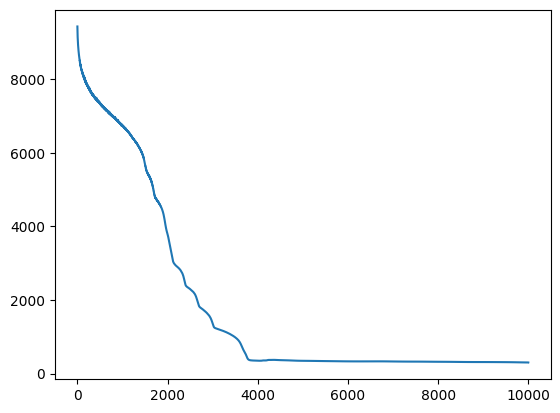

In [60]:
plt.plot(lossi)
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [61]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [62]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [63]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(in_features=n_in, out_features=n_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=n_hidden, out_features=n_out, bias=True),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [65]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.14427	accuracy (train, test): 0.10200	0.13000
step =   1000	loss=0.00005	accuracy (train, test): 1.00000	0.85200
step =   2000	loss=0.00001	accuracy (train, test): 1.00000	0.85300
step =   3000	loss=0.00017	accuracy (train, test): 1.00000	0.85200
step =   4000	loss=0.00009	accuracy (train, test): 1.00000	0.85600
step =   5000	loss=0.00002	accuracy (train, test): 1.00000	0.85400
step =   6000	loss=0.00007	accuracy (train, test): 1.00000	0.85500
step =   7000	loss=0.00000	accuracy (train, test): 1.00000	0.86000
step =   8000	loss=0.00003	accuracy (train, test): 1.00000	0.86100
step =   9000	loss=0.00006	accuracy (train, test): 1.00000	0.86000


##### Exercise: try to improve accuracy!

In [72]:
# network dimensions
n_in = 784
n_hidden1 = 500
n_hidden2 = 250
n_hidden3 = 125
n_hidden4 = 50
n_out = 10

X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(in_features=n_in, out_features=n_hidden1, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=n_hidden1, out_features=n_hidden2, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=n_hidden2, out_features=n_hidden3, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=n_hidden3, out_features=n_hidden4, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=n_hidden4, out_features=n_out, bias=True),
            nn.Softmax(dim=1)
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def train_my_network(nb_epochs=20**3):
    for n in range(nb_epochs):
        y_pred = model(X_tr)
        loss = loss_fn(y_pred, Y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if n % 1000 == 0: 
            with torch.no_grad():
                # train accuracy
                acc_train = compute_accuracy(y_pred, Y_tr)
                # test accuracy
                y_test_preds = model(X_test)
                acc_test = compute_accuracy(y_test_preds, Y_test)
                print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')
    
    print(f'{acc_train=}')
    print(f'{acc_test=}')
    print("Your Network has been trained!")

train_my_network()

step =      0	loss=0.05945	accuracy (train, test): 0.10900	0.10400
step =   1000	loss=0.00247	accuracy (train, test): 1.00000	0.86200
step =   2000	loss=0.00171	accuracy (train, test): 1.00000	0.87800
step =   3000	loss=0.00160	accuracy (train, test): 0.99900	0.86100
step =   4000	loss=0.00162	accuracy (train, test): 0.99900	0.87600
step =   5000	loss=0.00139	accuracy (train, test): 1.00000	0.86400
step =   6000	loss=0.00144	accuracy (train, test): 0.99900	0.87300
step =   7000	loss=0.00137	accuracy (train, test): 1.00000	0.86600
acc_train=1.0
acc_test=0.8659999966621399
Your Network has been trained!
